In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [2]:
train_dir = '/kaggle/input/mydataset/raf-db/train'
test_dir = '/kaggle/input/mydataset/raf-db/test'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path +"/"+ Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [3]:
pd.concat([Train_Count,Test_Count] , axis=1)

Train  Test
happy      4772  1185
neutral    2524   680
sad        1982   478
surprise   1290   329
disgust     717   160
angry       705   162
fear        281    74

<AxesSubplot:>

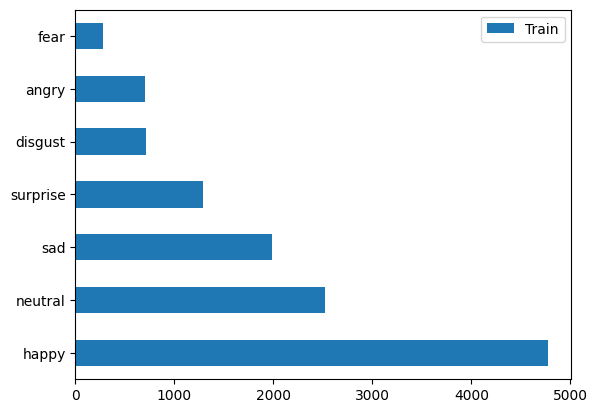

In [4]:
Train_Count.plot(kind='barh')

<AxesSubplot:>

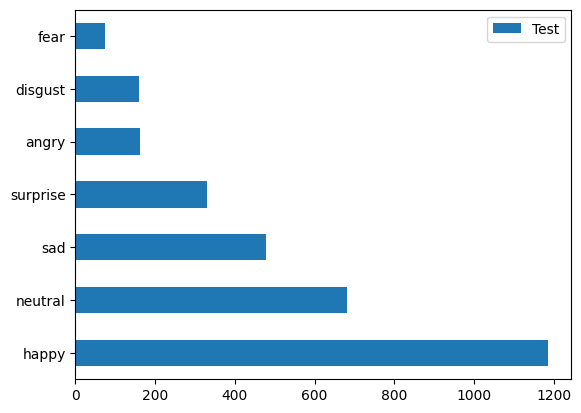

In [5]:
Test_Count.plot(kind='barh')

# **ResNet50V2 Model**

In [7]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = '/kaggle/input/mydataset/raf-db/train'
test_data_path = '/kaggle/input/mydataset/raf-db/test'

In [8]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


# **Fine-Tuning ResNet50V2**

In [9]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

ResNet50V2.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

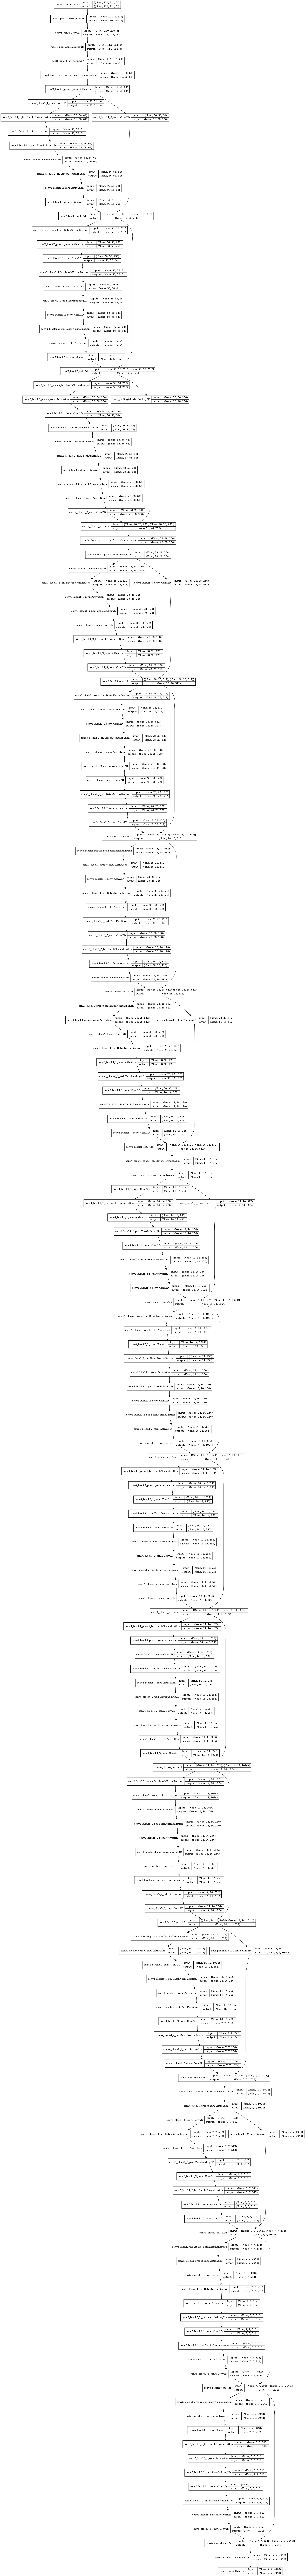

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(ResNet50V2, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [11]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [12]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [13]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

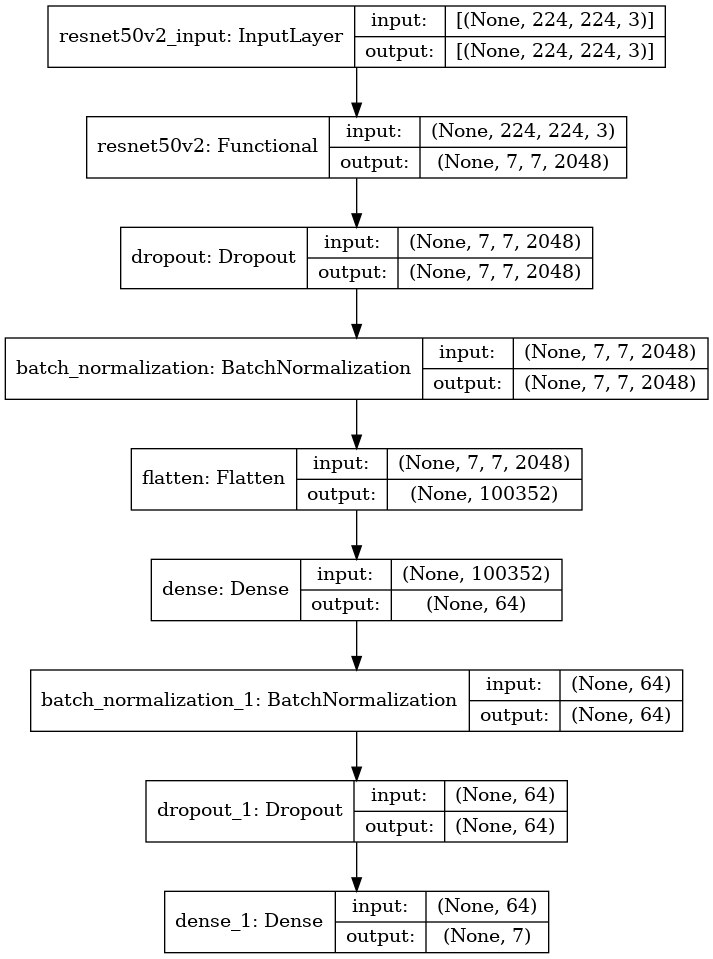

In [14]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(ResNet50V2_Model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

**Specifying Callbacks**

In [15]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [16]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30
191/191 [==============================] - 206s 1s/step - loss: 1.2900 - accuracy: 0.5802 - val_loss: 0.9554 - val_accuracy: 0.6991
Epoch 2/30
191/191 [==============================] - 164s 856ms/step - loss: 0.8320 - accuracy: 0.7292 - val_loss: 0.7733 - val_accuracy: 0.7450
Epoch 3/30
191/191 [==============================] - 161s 843ms/step - loss: 0.7564 - accuracy: 0.7508 - val_loss: 0.9013 - val_accuracy: 0.6832
Epoch 4/30
191/191 [==============================] - 155s 812ms/step - loss: 0.6598 - accuracy: 0.7817 - val_loss: 0.6449 - val_accuracy: 0.7889
Epoch 5/30
191/191 [==============================] - 156s 815ms/step - loss: 0.5855 - accuracy: 0.8064 - val_loss: 0.5649 - val_accuracy: 0.8158
Epoch 6/30
191/191 [==============================] - 158s 826ms/step - loss: 0.5420 - accuracy: 0.8188 - val_loss: 0.6036 - val_accuracy: 0.8029
Epoch 7/30
191/191 [==============================] - 157s 821ms/step - loss: 0.4960 - accuracy: 0.8345 - val_loss: 0.6612 - va

# **Evaluating ResNet50V2**

In [17]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

48/48 [==============================] - 9s 178ms/step - loss: 0.4686 - accuracy: 0.8523
    Test Loss: 0.46857
Test Accuracy: 85.23%


In [18]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

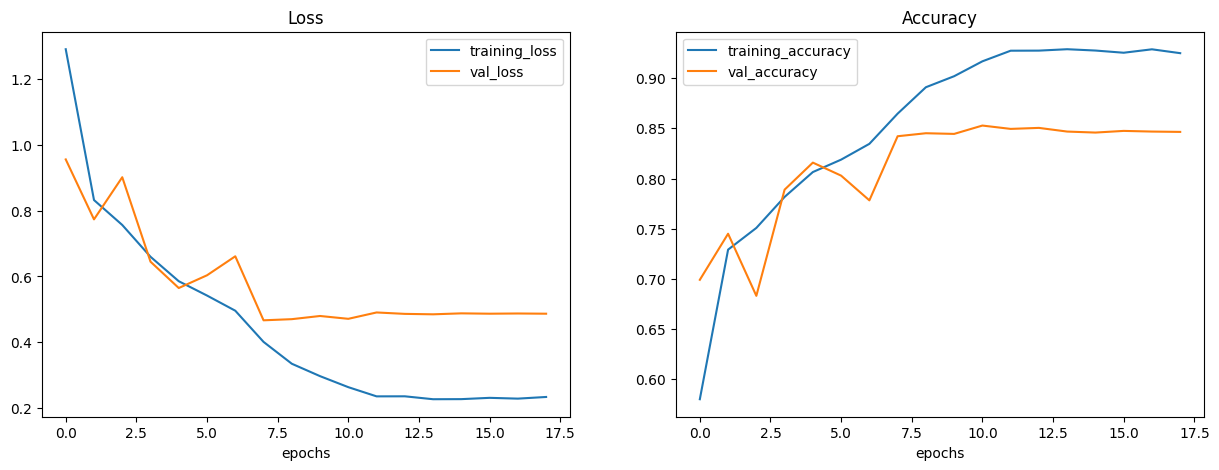

In [19]:
plot_curves(ResNet50V2_history)

In [20]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

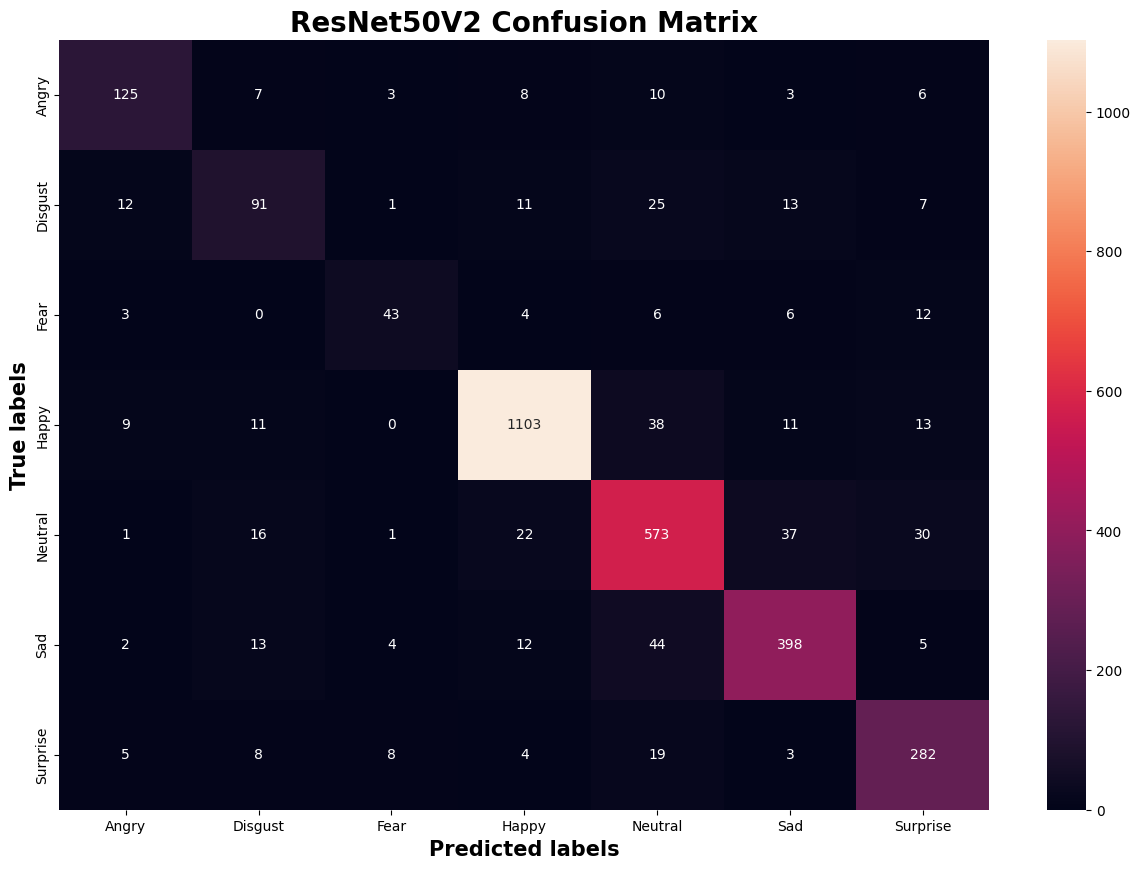

              precision    recall  f1-score   support

       Angry       0.80      0.77      0.78       162
     Disgust       0.62      0.57      0.59       160
        Fear       0.72      0.58      0.64        74
       Happy       0.95      0.93      0.94      1185
     Neutral       0.80      0.84      0.82       680
         Sad       0.85      0.83      0.84       478
    Surprise       0.79      0.86      0.82       329

    accuracy                           0.85      3068
   macro avg       0.79      0.77      0.78      3068
weighted avg       0.85      0.85      0.85      3068



In [31]:

# import seaborn as sns 
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt

# # Danh sách tên cảm xúc
# emotion_labels = ['Angry', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']

# fig , ax = plt.subplots(figsize=(15, 10))

# cm = confusion_matrix(test_data.labels, ResNet50V2_Predictions)

# sns.heatmap(cm, annot=True, fmt='g', ax=ax, xticklabels=emotion_labels, yticklabels=emotion_labels)

# ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
# ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
# ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# plt.show()
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
# Assuming `y_pred` are your predictions and `y_true` are the actual labels
cm = confusion_matrix(test_data.labels, ResNet50V2_Predictions)

# Define the list of emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming you have defined test_data.labels and ResNet50V2_Predictions
# and computed the confusion matrix (cm) beforehand

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, xticklabels=emotion_labels, yticklabels=emotion_labels)
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

# Generate and print the classification report
print(classification_report(test_data.labels, ResNet50V2_Predictions, target_names=emotion_labels))



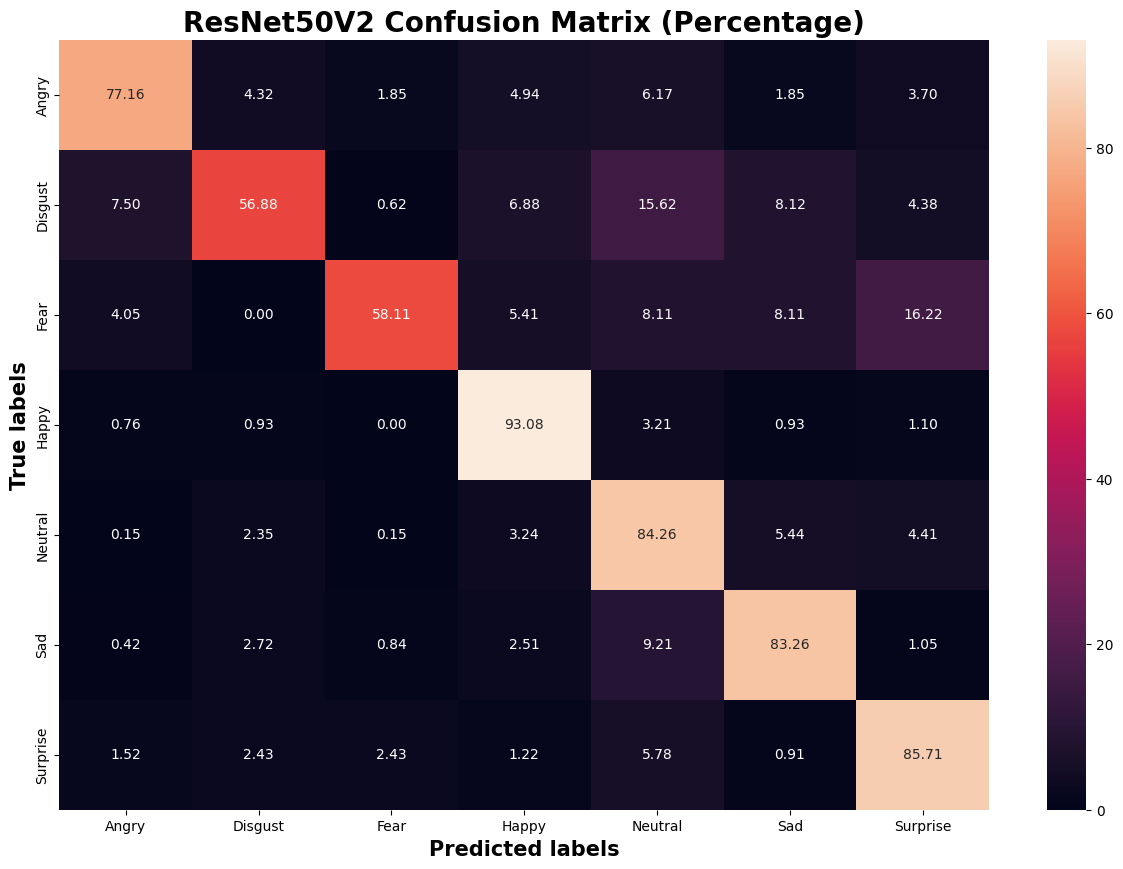

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tính toán ma trận phần trăm từ ma trận confusion
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(15, 10))

# Vẽ heatmap với ma trận phần trăm
sns.heatmap(cm_percent, annot=True, fmt='.2f', ax=ax, xticklabels=emotion_labels, yticklabels=emotion_labels)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix (Percentage)', fontsize=20, fontweight='bold')

plt.show()


In [35]:
# 'Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"
# print(classification_report(y_test, y_preds))

# **Visualizing Predictions**

In [24]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [25]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 3068 images belonging to 7 classes.


**ResNet50V2 Predictions**

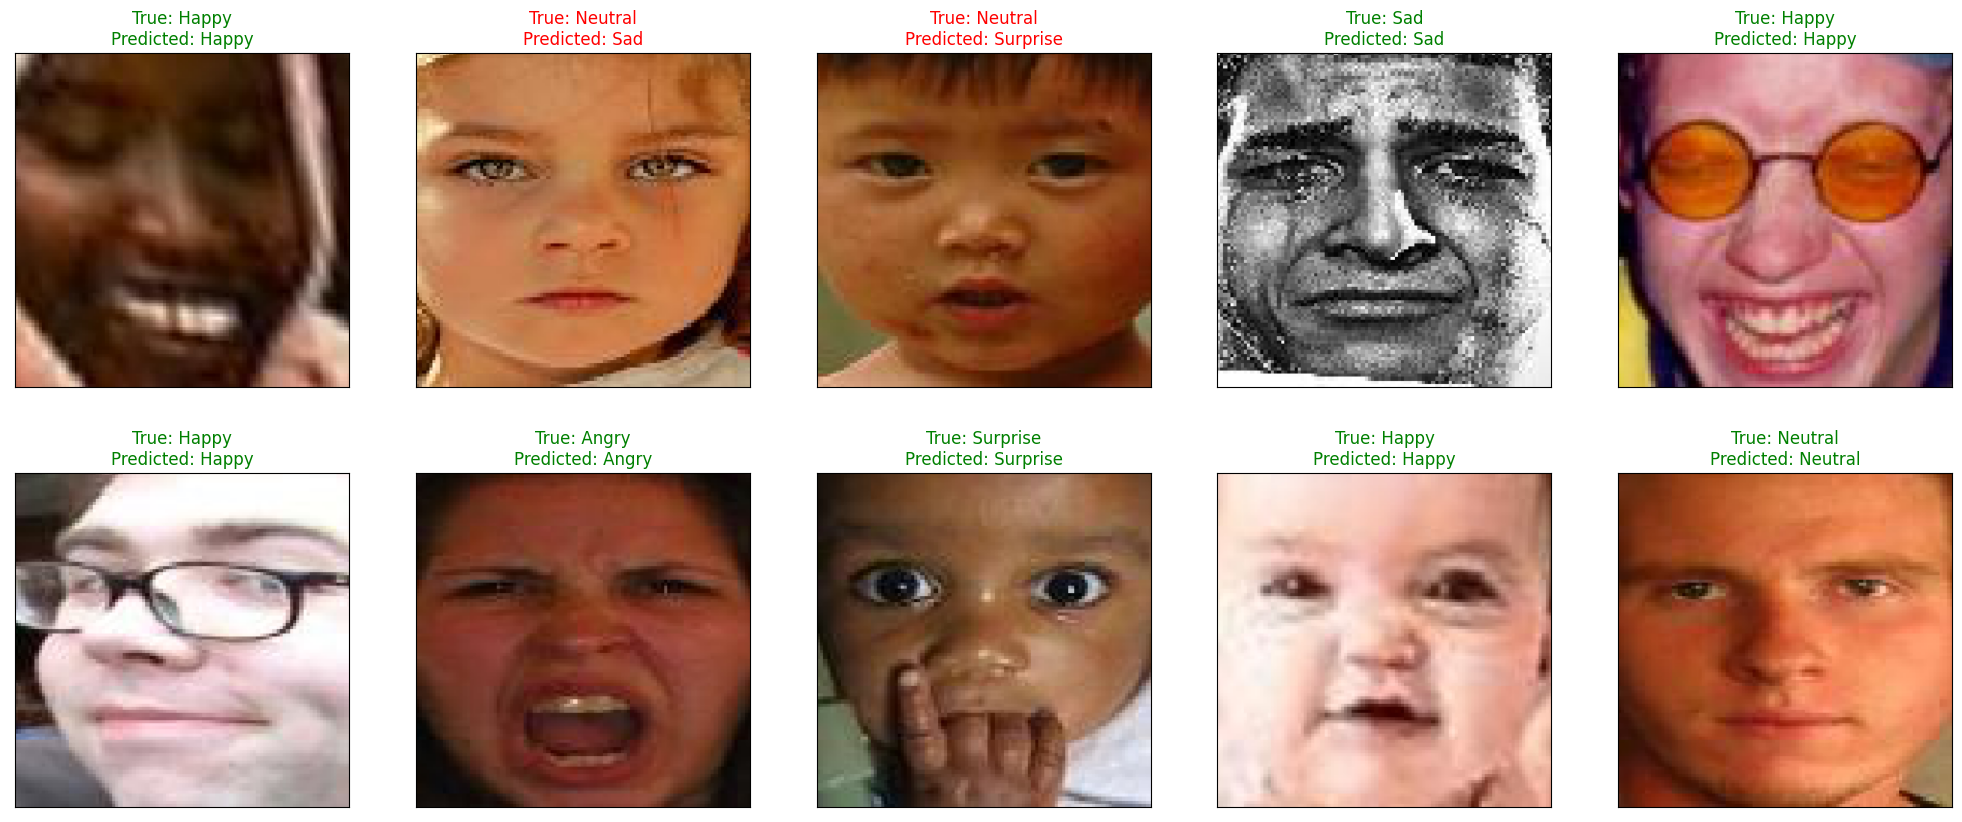

<Figure size 640x480 with 0 Axes>

In [26]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [39]:
# ResNet50V2_Model.save("ResNet50V2_Model.h5")

from keras.models import load_model

model = load_model('ResNet50V2_Model.h5')
model.save('ResNet50V2_Model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [40]:
import os
from IPython.display import FileLink

# Create a link to download the model file
if os.path.exists('ResNet50V2_Model.h5'):
    display(FileLink('ResNet50V2_Model.h5', result_html_prefix="Click here to download: "))
else:
    print("File not found.")


/kaggle/working/ResNet50V2_Model.h5

In [64]:
# import os

# # Specify the directory
# directory = "/kaggle/input/fer2013/test/sad"

# # List all files in the directory
# files = os.listdir(directory)
# print(files)

In [61]:
from keras.preprocessing import image

# Load the image
img_path = "/kaggle/input/fer2013/test/sad/PrivateTest_10247676.jpg"
img = image.load_img(img_path, target_size=(img_shape, img_shape))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image

# Make prediction
predictions = model.predict(img_array)

# Output the predictions
print("Predicted probabilities for each class:")
print(predictions)


# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Get the index of the highest predicted probability
predicted_index = np.argmax(predictions[0])

# Print the predicted emotion
predicted_emotion = emotion_labels[predicted_index]
print("Predicted emotion:", predicted_emotion)

Predicted probabilities for each class:
[[0.02903699 0.2687117  0.00406875 0.00206083 0.5625482  0.11680371
  0.01676979]]
Predicted emotion: Sad


In [44]:
import os

# Specify the directory
directory = "/kaggle/input/spotify-playlist-tracks"

# List all files in the directory
files = os.listdir(directory)
print(files)


['spotify_playlist_tracks.xlsx']


In [46]:
import pandas as pd

# Full path to the Excel file
file_path = "/kaggle/input/spotify-playlist-tracks/spotify_playlist_tracks.xlsx"

# Read the Excel file
df = pd.read_excel(file_path)

# Display the DataFrame
print(df.head())


                 track id                        track name   artist  \
0  7j7yBWX4dadRbJogeS0XiG           Mapleland (Login Theme)  Unknown   
1  5G2EDpLOK8STvBExDq80EG  Above the Treetops (Lith Harbor)  Unknown   
2  4qUpolpGvv8MmRCVmIscuK             Floral Life (Henesys)  Unknown   
3  08sys06Fj0YRVbhi5lk0ea           Bad Guys (Kerning City)  Unknown   
4  1XUwNNwCvciyFQgKFJMFY4             Missing You (Ellinia)  Unknown   

                                            shareUrl emotion  
0  https://open.spotify.com/track/7j7yBWX4dadRbJo...   Happy  
1  https://open.spotify.com/track/5G2EDpLOK8STvBE...   Happy  
2  https://open.spotify.com/track/4qUpolpGvv8MmRC...   Happy  
3  https://open.spotify.com/track/08sys06Fj0YRVbh...   Happy  
4  https://open.spotify.com/track/1XUwNNwCvciyFQg...   Happy  


In [63]:
import random

# Convert predicted emotion to lowercase
predicted_emotion_lower = predicted_emotion.lower()

# Filter the dataset based on the predicted emotion (converted to lowercase)
filtered_df = df[df['emotion'].str.lower() == predicted_emotion_lower]

# Check if any songs are found for the predicted emotion
if len(filtered_df) == 0:
    print("No songs found for predicted emotion:", predicted_emotion)
else:
    # Randomly pick a song from the filtered dataframe
    random_song_index = random.randint(0, len(filtered_df) - 1)
    random_song = filtered_df.iloc[random_song_index]

    # Print the randomly picked song
    print("Randomly picked song for predicted emotion:", predicted_emotion)
    print("Track Name:", random_song['track name'])
    print("Emotion:", random_song['emotion'])

    # Display a clickable link to play the song on Spotify
    spotify_url = random_song['shareUrl']
    display(HTML(f'<a href="{spotify_url}" target="_blank">Click here to play "{random_song["track name"]}" on Spotify</a>'))


Randomly picked song for predicted emotion: Sad
Track Name: Venice
Emotion: Sad
